In [0]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch.nn.functional as F
from torch.distributions import Normal
import torch.nn as nn
import os
import torch.optim as optim
from torch.distributions import Normal, Uniform

In [0]:
def sample_data():
  count = 100000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

X shape:  (99999, 2)
y shape:  (99999,)


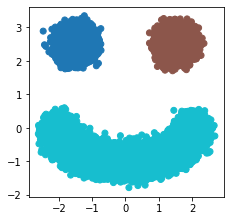

In [64]:
X, y = sample_data()
print("X shape: ", X.shape)
print("y shape: ", y.shape)

plt.figure(figsize=(3.5, 3.5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10')
plt.show()

In [65]:
split = int(0.8 * 100000)
X_train, X_test = X[:split,], X[split:,]
y_train, y_test = y[:split,], y[split:,]

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (80000, 2)
X_test shape:  (19999, 2)


In [0]:
class DataLoader:
  def __init__(self, data, target, batch_size=10):
    self.data = data
    self.target = target
    self.batch_size = batch_size

  def next(self):
    m, _ = self.data.shape
    rand_index = np.random.choice(m, size=m)
    X, y = self.data[rand_index], self.target[rand_index]
    pos = 0
    while pos < m:
      X_batch, y_batch = X[pos:pos+self.batch_size], y[pos:pos+self.batch_size]
      yield (X_batch, y_batch)
      pos += self.batch_size

  def __call__(self):
    return self.next()

### Autoregressive Flow

In [0]:
class BufferedLinear(nn.Linear):
  def __init__(self, in_features, out_features, bias=True):
    super(BufferedLinear, self).__init__(in_features, out_features, bias=bias)
    self.register_buffer("buffer", torch.ones([out_features, in_features]).float())
      
  def set_buffer(self, buffer):
    self.buffer = buffer.data
      
  def forward(self, x):
    return F.linear(x, self.buffer * self.weight, self.bias)
    
class BaseNN(nn.Module):
  def __init__(self, k, hidden_size):
    super(BaseNN, self).__init__()
    self.k = k
    self.h = hidden_size
    
    buf1 = np.ones([self.h, 2], dtype=np.float32)
    buf1[:, 1] = 0.0
    self.linear1 = BufferedLinear(2, self.h)
    self.linear1.set_buffer(torch.from_numpy(buf1))
    
    buf2 = np.ones([2 * k, self.h], dtype=np.float32)
    buf2[:k, :] = 0.0
    self.linear2 = BufferedLinear(self.h, 2 * k)
    self.linear2.set_buffer(torch.from_numpy(buf2))

In [0]:
class CoeffNN(BaseNN):
  def __init__(self, k, hidden_size):
    super().__init__(k, hidden_size)
      
  def forward(self, x):
    lin1 = self.linear1(x)
    h = F.relu(lin1)
    lin2 = self.linear2(h)
    lin2 = lin2.reshape([-1, 2, self.k])
    sftmx = F.softmax(lin2, dim=2)
    return sftmx
    
class MeanNN(BaseNN):
  def __init__(self, k, hidden_size):
    super().__init__(k, hidden_size)
      
  def forward(self, x):
    lin1 = self.linear1(x)
    h = F.relu(lin1)
    lin2 = self.linear2(h)
    lin2 = lin2.view([-1, 2, self.k])
    return lin2
    
class VarNN(BaseNN):
  def __init__(self, k, hidden_size):
    super().__init__(k, hidden_size)
      
  def forward(self, x):
    lin1 = self.linear1(x)
    h = F.relu(lin1)
    lin2 = self.linear2(h)
    exp = torch.exp(lin2)
    out = exp.view([-1, 2, self.k])
    return out

In [0]:
class MyModel:
  def __init__(self, k, hidden_size):
    self.k = k
    self.hidden_size = hidden_size

    self.coeffNN = CoeffNN(k, hidden_size).cuda()
    self.meanNN = MeanNN(k, hidden_size).cuda()
    self.varNN = VarNN(k, hidden_size).cuda()

  def loss(self, x):
    coeff, mean, var = self.coeffNN(x), self.meanNN(x), self.varNN(x)
    x = x.unsqueeze(2)
    w_dens = coeff * torch.exp(-torch.pow(x - mean, 2) / (2 * var)) / torch.sqrt(2 * np.pi * var)
    dens = torch.sum(w_dens, dim=2)
    return -torch.log(torch.abs(dens[:, 0] * dens[:, 1]))

  def parameters(self):
    return list(self.coeffNN.parameters()) + list(self.meanNN.parameters()) + list(self.varNN.parameters())

  def density(self, x):
    coeff, mean, var = self.coeffNN(x), self.meanNN(x), self.varNN(x)
    x = x.unsqueeze(2)
    w_dens = coeff * torch.exp(-torch.pow(x - mean, 2) / (2 * var)) / torch.sqrt(2 * np.pi * var)

    dens = torch.sum(w_dens, dim=2)
  
    return torch.abs(dens[:, 0] * dens[:, 1]).detach()

  def inverse(self, z):
    z1, z2 = z[:, 0], z[:, 1]

    x1 = torch.zeros(z.shape[0]).float().cuda()
    x2 = torch.zeros(z.shape[0]).float().cuda()

    coeff, mean, var = self.coeffNN(z), self.meanNN(z), self.varNN(z)

    pi1, mu1, sigma1 = coeff[:, 0, :], mean[:, 0, :], var[:, 0, :]

    for i in range(z.shape[0]):
      j = np.random.choice(self.k, p=pi1[i].detach().cpu().data.numpy())
      x1[i] = Normal(mu1[i, j], torch.sqrt(sigma1[i, j])).icdf(z1[i])

    x = torch.stack((x1, x1), dim=1)

    coeff, mean, var = self.coeffNN(x), self.meanNN(x), self.varNN(x)

    pi2, mu2, sigma2 = coeff[:, 1, :], mean[:, 1, :], var[:, 1, :]
    for i in range(z.shape[0]):
      j = np.random.choice(self.k, p=pi2[i].detach().cpu().data.numpy())
      x2[i] = Normal(mu2[i, j], torch.sqrt(sigma2[i, j])).icdf(z2[i])

    return x1, x2

  def latent(self, x):
    coeff, mean, var = self.coeffNN(x), self.meanNN(x), self.varNN(x)
    x = x.unsqueeze(2)
    w_cdf = coeff * (torch.erf((x - mean) / torch.sqrt(2 * var)) + 1) / 2
    cdf = torch.sum(w_cdf, dim=2)
    return cdf

In [0]:
# Hyperparameters
k = 10
hidden_size = 100
lr = 1e-3
NUM_EPOCHS = 15
BATCH_SIZE = 256

In [299]:
model = MyModel(k, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=lr)

dataloader = DataLoader(np.array(X_train), np.array(y_train), batch_size=BATCH_SIZE)

train_x = []
train_losses = []
val_x = []
val_losses = []

global_step = 0

val_loss = torch.mean(model.loss(torch.from_numpy(X_test).float().cuda()).detach())
val_loss = val_loss / (2 * np.log(2))
val_x.append(global_step)
val_losses.append(val_loss.item())

for epoch in range(NUM_EPOCHS):
  loss = None

  for data in dataloader():
    inputs, targets = data
    batch = torch.from_numpy(inputs).float().cuda()
    
    loss = torch.mean(model.loss(batch))
    
    if (global_step + 1) % 300 == 0:
      print(f"EPOCH:{epoch + 1}/{NUM_EPOCHS}, GLOBAL_STEP:{global_step + 1} LOSS={loss.item()}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss = loss.detach() / (2 * np.log(2))
    train_x.append(global_step)
    train_losses.append(train_loss.item())
    
    global_step += 1
      
  val_loss = torch.mean(model.loss(torch.from_numpy(X_test).float().cuda()).detach())
  val_loss = val_loss / (2 * np.log(2))
  val_x.append(global_step)
  val_losses.append(val_loss.item())


EPOCH:1/15, GLOBAL_STEP:300 LOSS=2.3429434299468994
EPOCH:2/15, GLOBAL_STEP:600 LOSS=2.1608400344848633
EPOCH:3/15, GLOBAL_STEP:900 LOSS=2.044158458709717
EPOCH:4/15, GLOBAL_STEP:1200 LOSS=1.9878547191619873
EPOCH:5/15, GLOBAL_STEP:1500 LOSS=1.7341821193695068
EPOCH:6/15, GLOBAL_STEP:1800 LOSS=1.6261988878250122
EPOCH:7/15, GLOBAL_STEP:2100 LOSS=1.7112326622009277
EPOCH:8/15, GLOBAL_STEP:2400 LOSS=1.4451266527175903
EPOCH:9/15, GLOBAL_STEP:2700 LOSS=1.2985866069793701
EPOCH:10/15, GLOBAL_STEP:3000 LOSS=1.3954362869262695
EPOCH:11/15, GLOBAL_STEP:3300 LOSS=1.3431662321090698
EPOCH:12/15, GLOBAL_STEP:3600 LOSS=1.34693443775177
EPOCH:13/15, GLOBAL_STEP:3900 LOSS=1.3054380416870117
EPOCH:14/15, GLOBAL_STEP:4200 LOSS=1.364678978919983
EPOCH:15/15, GLOBAL_STEP:4500 LOSS=1.4177062511444092


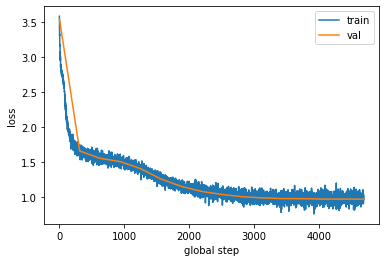

Final test performance: 0.9656971096992493


In [300]:
plt.plot(train_x, train_losses, label="train")
plt.plot(val_x, val_losses, label="val")
plt.xlabel("global step")
plt.ylabel("loss")
plt.legend()
plt.show()

loss = torch.mean(model.loss(torch.from_numpy(X_test).float().cuda()).detach())
bits = loss / (2 * np.log(2))
print(f"Final test performance: {bits.item()}")

([<matplotlib.axis.YTick at 0x7fabefbab668>,
 <a list of 9 Text yticklabel objects>)

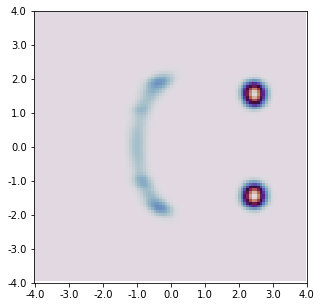

In [303]:
space = np.linspace(-4, 4, 100)

samples = torch.from_numpy(np.array(np.meshgrid(space, space)).T.reshape([-1, 2])).float().cuda()
pdf = model.density(samples).cpu().data.numpy().reshape(100, 100)

plt.figure(figsize=(5, 5))
plt.imshow(pdf, cmap="twilight")
plt.xticks(np.linspace(0, 100, 9), np.linspace(-4, 4, 9))
plt.yticks(np.linspace(0, 100, 9), np.linspace(4, -4, 9))

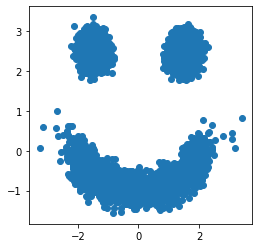

In [307]:
A = torch.tensor([0.0]).float().cuda()
B = torch.tensor([1.0]).float().cuda()
z = Uniform(A, B).rsample((10000, 2)).reshape(10000, 2)
plt.figure(figsize=(4, 4))
x1, x2 = model.inverse(z)
x1 = x1.cpu().detach().numpy()
x2 = x2.cpu().detach().numpy()
plt.scatter(x1, x2)

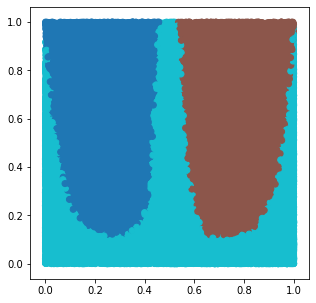

In [308]:
lat = model.latent(torch.from_numpy(X).float().cuda()).data.cpu().data.numpy()
plt.figure(figsize=(5, 5))
plt.scatter(lat[:, 0], lat[:, 1], c=y, cmap='tab10')
plt.show()

### RealNVP

In [0]:
class BaseLayer(nn.Module):
  def __init__(self, hidden_size):
    super(BaseLayer, self).__init__()
    self.lin1 = nn.Linear(2, hidden_size)
    self.lin2 = nn.Linear(hidden_size, hidden_size)
    self.lin3 = nn.Linear(hidden_size, 2)
    self.prelu = nn.PReLU()

  def forward(self,x):
    lin1 = self.lin1(x)
    relu = torch.relu(lin1)
    lin2 = self.lin2(relu)
    relu = torch.relu(lin2)
    z = self.lin3(relu)
    a = torch.tanh(z[:,0])
    b = self.prelu(z[:,1])
    y = torch.stack([a, b])
    return y.permute(1, 0)

In [0]:
class CouplingLayer(nn.Module):
  def __init__(self, hidden_size, mask):
    super(CouplingLayer, self).__init__()
    self.s = BaseLayer(hidden_size).cuda()
    self.mask = mask.bool()

  def forward(self, x):
    a = self.s(x * self.mask)
    mask = self.mask.repeat(x.shape[0], 1)
    y1 = x[~mask] * torch.exp(a[:, 0]) + a[:, 1]

    if(self.mask[0]):
      y = torch.stack([x[mask], y1])
    else:
      y = torch.stack([y1, x[mask]])

    return (y.permute(1, 0), a[:, 0])

  def inverse(self, x):
    a = self.s(x * self.mask)
    mask = self.mask.repeat(x.shape[0], 1)
    y1 = (x[~mask] - a[:, 1]) * torch.exp(-a[:, 0])

    if(self.mask[0]):
      y = torch.stack([x[mask], y1])
    else:
      y = torch.stack([y1, x[mask]])

    return y.permute(1, 0)

In [0]:
class RealNVP(nn.Module):
  def __init__(self, hidden_size, k):
    super(RealNVP, self).__init__()
    self.k = k
    mask = torch.tensor([[1,0], [0,1]] * k, dtype=bool).float().cuda()
    self.coupling_layers = [CouplingLayer(hidden_size, mask[i]).cuda() for i in range(k)]

  def forward(self,x):
    cs = []

    for i in range(self.k):
      x, c = self.coupling_layers[i](x)
      cs.append(c)

    y = torch.sigmoid(x)
    return y, x, cs

  def density(self, x):
    log_prob = torch.zeros((x.shape[0], 1)).cuda()
    z = x

    for i in range(self.k):
      log_prob += self.coupling_layers[i](z)[1].unsqueeze(1)
      z = self.coupling_layers[i].forward(z)[0]

    z = torch.sigmoid(z)
    log_prob += torch.log(z * (1 - z) + 1e-9).sum(dim=1).view(-1, 1)

    return log_prob.exp()

  def parameters(self):
    params = []
    for i in range(self.k):
      params += list(self.coupling_layers[i].parameters())
    return params

  def inverse(self, y):
    y = torch.log(y / (1 - y))
    inv = y

    for i in range(self.k - 1, -1, -1):
      #print(i)
      inv = self.coupling_layers[i].inverse(inv)

    return inv

In [0]:
def loss_func(x, cs):
  loss = 2 * torch.sum(F.logsigmoid(x)) - torch.sum(x)
  for c in cs:
    loss += torch.sum(c)
  return -loss

In [0]:
# Hyperparameters
k = 4
hidden_size = 10
lr = 1e-2
NUM_EPOCHS = 15
BATCH_SIZE = 512

In [175]:
model = RealNVP(hidden_size, k)
optimizer = optim.Adam(model.parameters(), lr=lr)

dataloader = DataLoader(np.array(X_train), np.array(y_train), batch_size=BATCH_SIZE)

train_x = []
train_losses = []
val_x = []
val_losses = []

global_step = 0

_, z1, cs = model(torch.from_numpy(X_test).float().cuda())
val_loss = loss_func(z1, cs) / X_test.shape[0]
val_loss = val_loss / (2 * np.log(2))
val_x.append(global_step)
val_losses.append(val_loss.item())

for epoch in range(NUM_EPOCHS):
  loss = None

  for data in dataloader():
    inputs, targets = data
    batch = torch.from_numpy(inputs).float().cuda()
    
    _, z1, cs = model(batch)
    loss = loss_func(z1, cs) / batch.shape[0]
    
    if (global_step + 1) % 300 == 0:
      print(f"EPOCH:{epoch + 1}/{NUM_EPOCHS}, GLOBAL_STEP:{global_step + 1} LOSS={loss.item()}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss = loss.detach() / (2 * np.log(2))
    train_x.append(global_step)
    train_losses.append(train_loss.item())
    
    global_step += 1
      
  _, z1, cs = model(torch.from_numpy(X_test).float().cuda())
  val_loss = loss_func(z1, cs) / X_test.shape[0]
  val_loss = val_loss / (2 * np.log(2))
  val_x.append(global_step)
  val_losses.append(val_loss.item())

EPOCH:2/15, GLOBAL_STEP:300 LOSS=1.75252366065979
EPOCH:4/15, GLOBAL_STEP:600 LOSS=1.491097092628479
EPOCH:6/15, GLOBAL_STEP:900 LOSS=1.5552568435668945
EPOCH:8/15, GLOBAL_STEP:1200 LOSS=1.4580063819885254
EPOCH:10/15, GLOBAL_STEP:1500 LOSS=1.4599018096923828
EPOCH:12/15, GLOBAL_STEP:1800 LOSS=1.5318081378936768
EPOCH:14/15, GLOBAL_STEP:2100 LOSS=1.5247092247009277


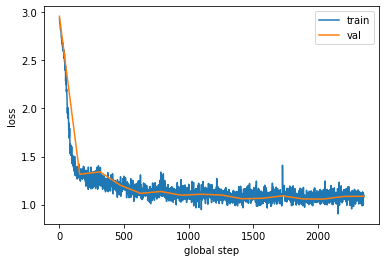

Final test performance: 1.0869985818862915


In [176]:
plt.plot(train_x, train_losses, label="train")
plt.plot(val_x, val_losses, label="val")
plt.xlabel("global step")
plt.ylabel("loss")
plt.legend()
plt.show()

_, z1, cs = model(torch.from_numpy(X_test).float().cuda())
val_loss = loss_func(z1, cs) / X_test.shape[0]
val_loss = val_loss / (2 * np.log(2))
print(f"Final test performance: {val_loss.item()}")

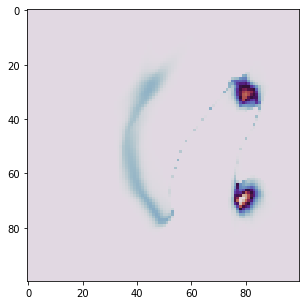

In [182]:
d = np.linspace(-4, 4, 100)
plt.figure(figsize=(5, 5))
samples = np.array(np.meshgrid(d, d)).T.reshape([-1, 2])
samples = torch.from_numpy(samples).float().cuda()
pdf = model.density(samples).cpu().detach().numpy().reshape(100, 100)
plt.imshow(pdf, cmap="twilight")
plt.show()

3
2
1
0


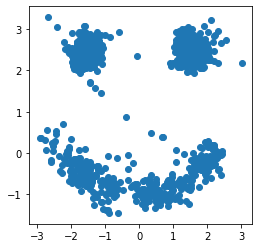

In [186]:
data = torch.FloatTensor(1000, 2).cuda().uniform_(0,1)
data_np = data.data.cpu().data.numpy()
smpl = model.inverse(data)

plt.figure(figsize=(4, 4))
data_np = smpl.detach().data.cpu().data.numpy()
plt.scatter(data_np[:, 0], data_np[:, 1])
plt.show()

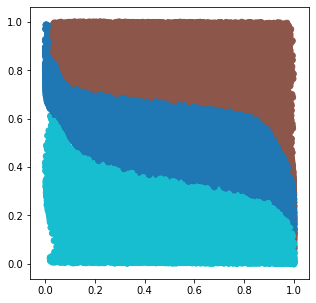

In [187]:
z2, z1, cs = model(torch.from_numpy(X).float().cuda())
res = z2.detach().data.cpu().data.numpy()
plt.figure(figsize=(5, 5))
plt.scatter(res[:, 0], res[:, 1], c=y, cmap="tab10")
plt.show()